# Analyzing the 2008 US Presidential Elections

In [21]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern3 import web
import matplotlib as mpl
import bs4
from bs4 import BeautifulSoup

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = matplotlib.cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [1]:
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [24]:
from collections import defaultdict
import json

#load in state geometry
state2poly = defaultdict(list)

with open ("data/us-states.json") as json_file:
    data = json.load(json_file)
    for f in data['features']:
        state = states_abbrev[f['id']]
        geo = f['geometry']
        if geo['type'] == 'Polygon':
            for coords in geo['coordinates']:
                state2poly[state].append(coords)
        elif geo['type'] == 'MultiPolygon':
            for polygon in geo['coordinates']:
                state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = matplotlib.cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = matplotlib.cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    #remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [10]:
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

## Background: The Electoral College

US Presidential elections revolve around the <a href="http://en.wikipedia.org/wiki/Electoral_College_(United_States)"> Electoral College </a>. In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President. 

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.)

Here is the electoral vote breakdown by state:

*As a matter of convention, we will index all our dataframes by the state name*

In [13]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

Votes
State            
California     55
Texas          38
New York       29
Florida        29
Illinois       20

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


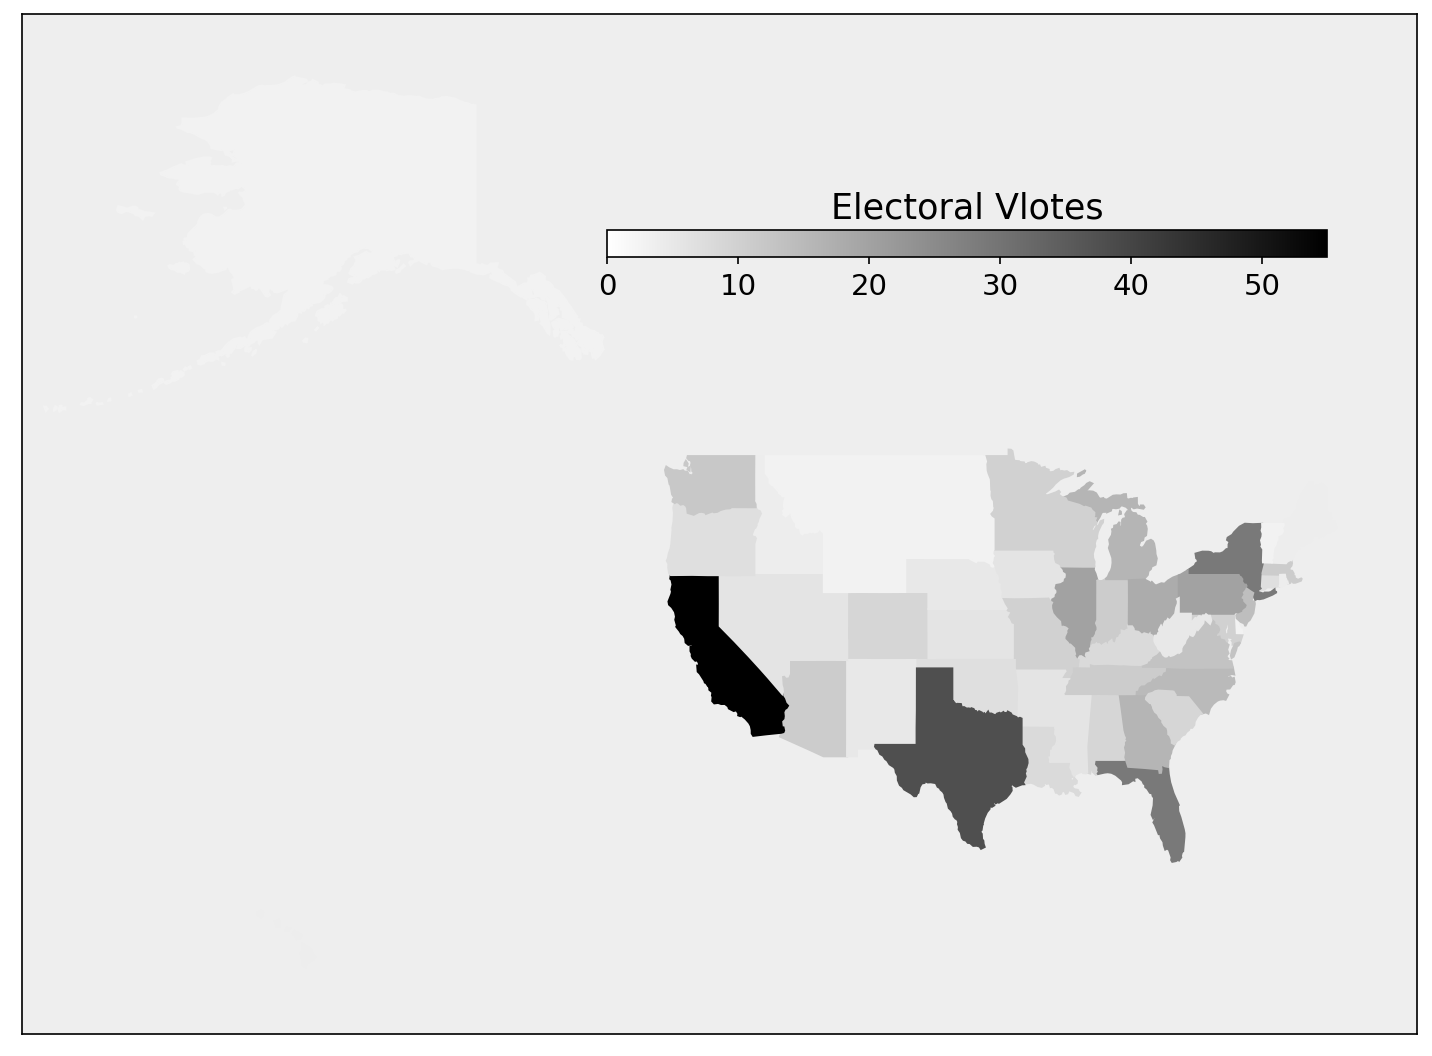

In [25]:
make_map(electoral_votes.Votes, "Electoral Vlotes");

#### The PredictWise Baseline

We will start by examining a successful forecast that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012. This will give us a point of comparison for our own forecast models.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

In [26]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

Obama  Romney  Votes
States                          
Alabama     0.000   1.000      9
Alaska      0.000   1.000      3
Arizona     0.062   0.938     11
Arkansas    0.000   1.000      6
California  1.000   0.000     55

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


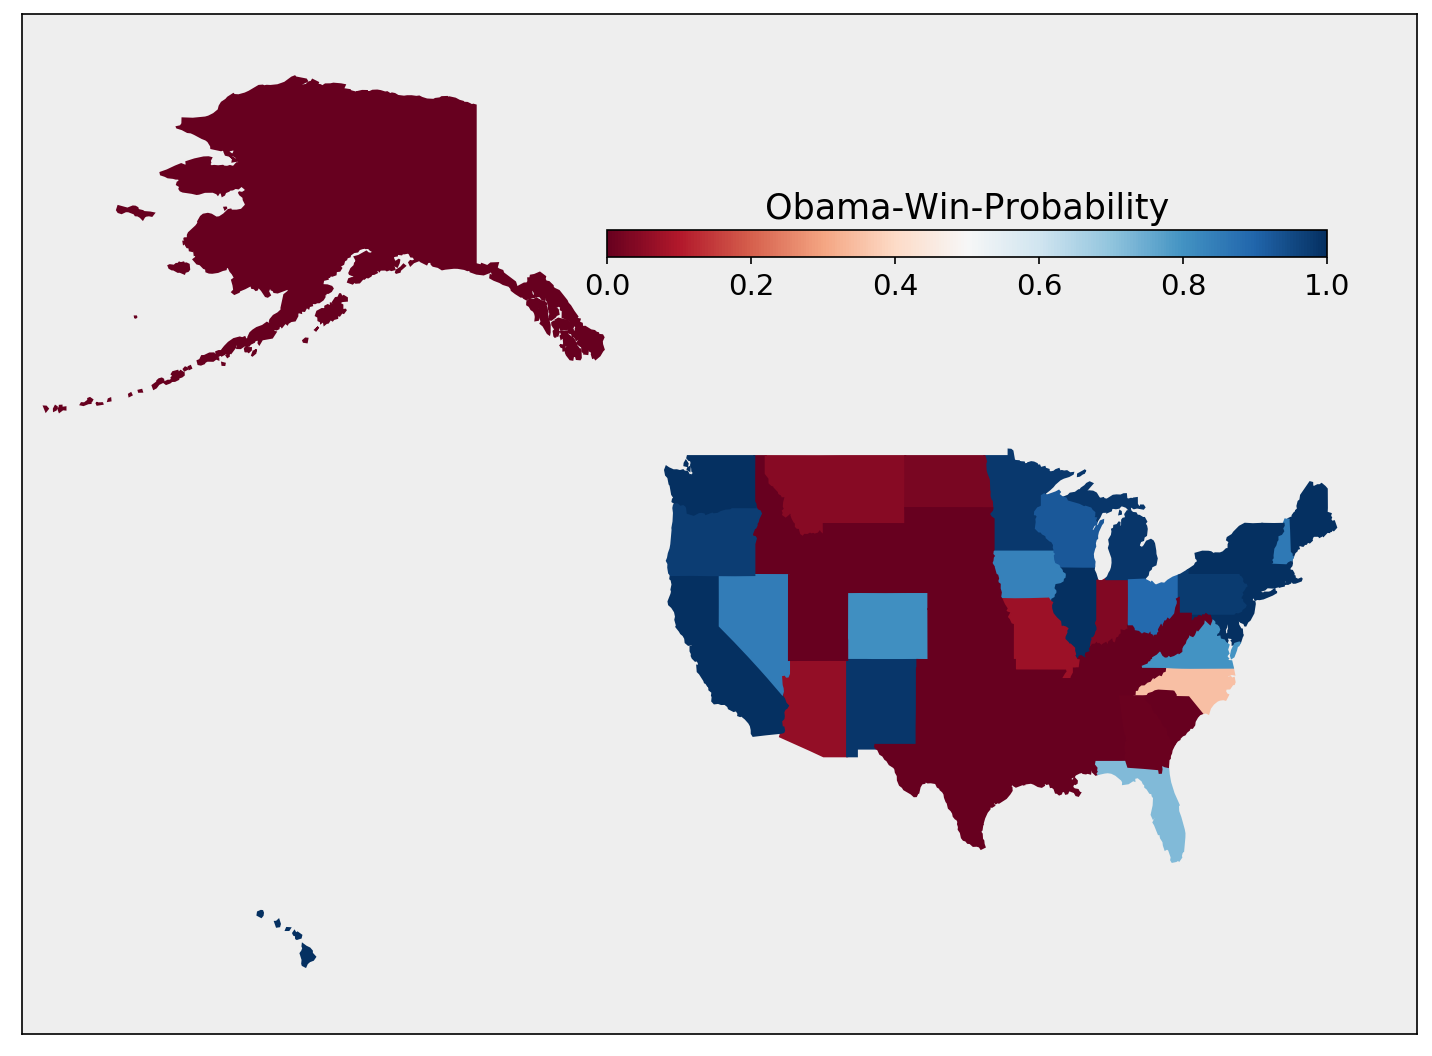

In [27]:
make_map(predictwise.Obama,"Obama-Win-Probability")

We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities.

In [75]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""

def simulate_election(model,n_sim):
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    return obama_votes.sum(axis=0)

In [76]:
result = simulate_election(predictwise, 10000)

In [105]:
np.sum(result>269)/result.size

0.9957

In [82]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes Obama wins in each simulation.
    
Returns
-------
Nothing 
"""
def plot_simulation(simulation):
    plt.hist(simulation,label='simulations', align='left', density=True,alpha = 0.9,rwidth = 0.8,bins = 70)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean()*100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    plt.show()


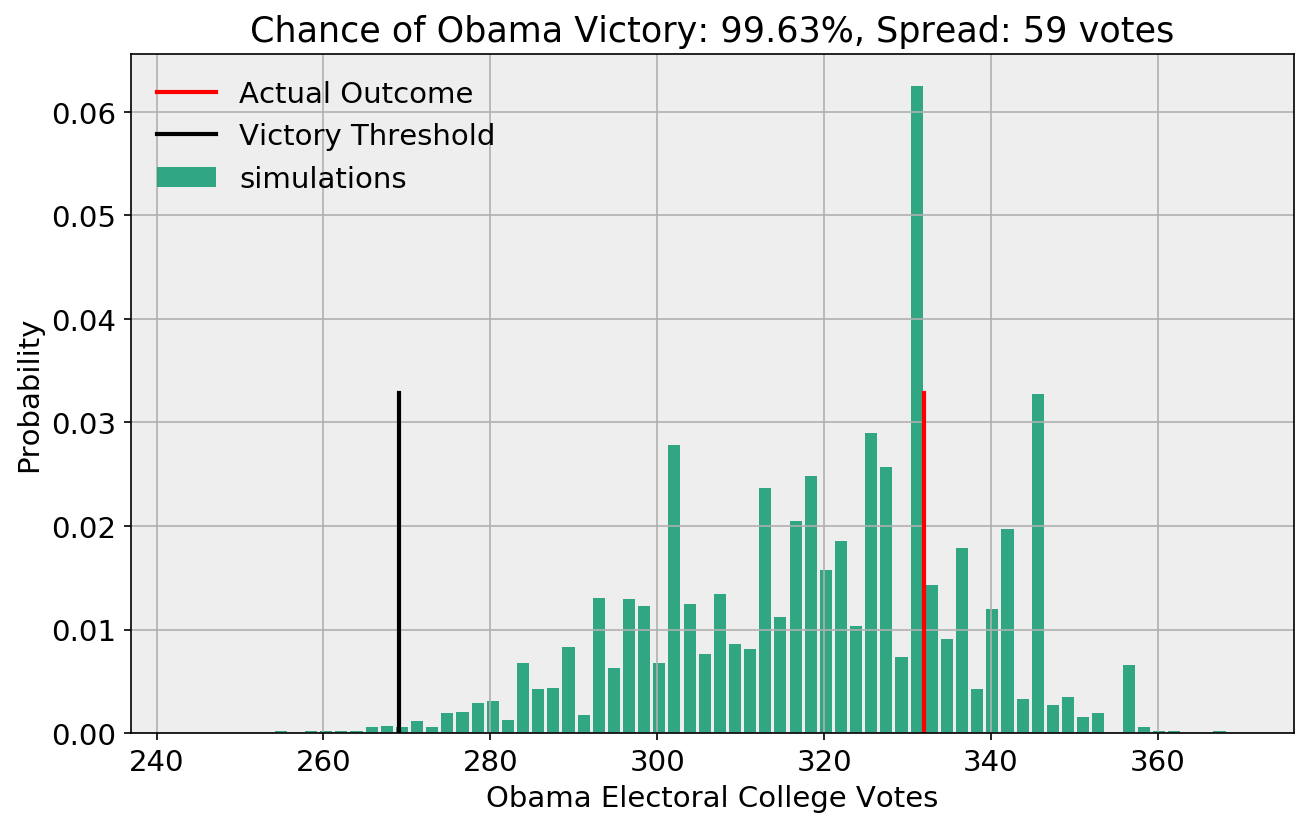

In [85]:
plot_simulation(result)

Now we **evaluate** our prediction to get a sense of how useful it is, and we **validate** the predictive model by comparing it to real data.

To evaluate the **accuracy** of our prediction, we can check to see whether the expectation of our predictive distribution seems to match the expectation of the true outcome. In this case, much of the predictive distribution's mass lies on or around the real outcome (that is, the histogram is approximately centered on the actual outcome of Obama=332 votes). So, based on the outcome we observed, the model seems accurate. To make a more rigorous statement about accuracy, we would want to have more replications (that is, more elections) to see whether the expectation of the predictive distribution consistently matches the true outcomes.

To evaluate the **precision** of our prediction, we look at the spread of the histogram. Because we are assuming the model is correct, we can interpret the spread of the histogram as a measure of the variability among the election outcomes that are consistent with the information we have. If our current information does not constrain the likely election outcomes very much, then the difference between our prediction and the true outcome can vary widely. The spread of the histogram is 60 votes, which is relatively large. Whether the prediction is precise *enough* is a question of what you want to do with your prediction. For example, if you want to be able to call the winner of a close election (say the candidates are separated by less than 30 votes), this prediction would not be precise enough to identify a winner with 95% confidence. To handle this, we might wish to incorporate more information into the model to reduce the spread of likely election outcomes.

The graph shows a hypothesis test. The histogram approximates the predictive distribution of election outcomes (in terms of electoral votes) *assuming our model for the election is true*. By comparing this to the true outcome of the election, we can see whether the observed electoral vote count would be highly atypical if the model were true. In this case, it appears the true outcome is quite typical among the model's predicted outcomes, so we do not reject our model.

In this case, we have checked only one prediction, since there is only one true outcome that we've compared to the predictive distribution.

To increase our confidence, we would want to test more outcomes against predictions that were made in the same way. For example, we could apply the same procedure (including PredictWise's computation of the statewise probability estimates) to different elections and see whether each of the hypothesis tests fails to reject the model in those cases as well. We could also break the election down into state-by-state outcomes, and test the prediction for each state against that state's outcome.


### Gallup Party Affiliation Poll

## Now we will try to **estimate** our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. [Here's the data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [96]:
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

Democrat  Republican  Dem_Adv      N  Unknown
State                                                    
Alabama         36.0        49.6    -13.6   3197     14.4
Alaska          35.9        44.3     -8.4    402     19.8
Arizona         39.8        47.3     -7.5   4325     12.9
Arkansas        41.5        40.8      0.7   2071     17.7
California      48.3        34.6     13.7  16197     17.1

In [101]:
"""
Function
--------
simple_gallup_model

A simple forecast that predicts an Obama (Democratic) victory with
0 or 100% probability, depending on whether a state
leans Republican or Democrat.

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama. All values should be 0 or 1
    model.index should be set to gallup.index (that is, it should be indexed by state name)
    
Examples
---------
>>> simple_gallup_model(gallup_2012).ix['Florida']
Obama    1
Name: Florida, dtype: float64
>>> simple_gallup_model(gallup_2012).ix['Arizona']
Obama    0
Name: Arizona, dtype: float64
"""

def simple_gallup_model(gallup):
    df = pd.DataFrame()
    df['Obama'] = (gallup_2012[gallup_2012.columns[2]] > 0) * 1.0
    return df

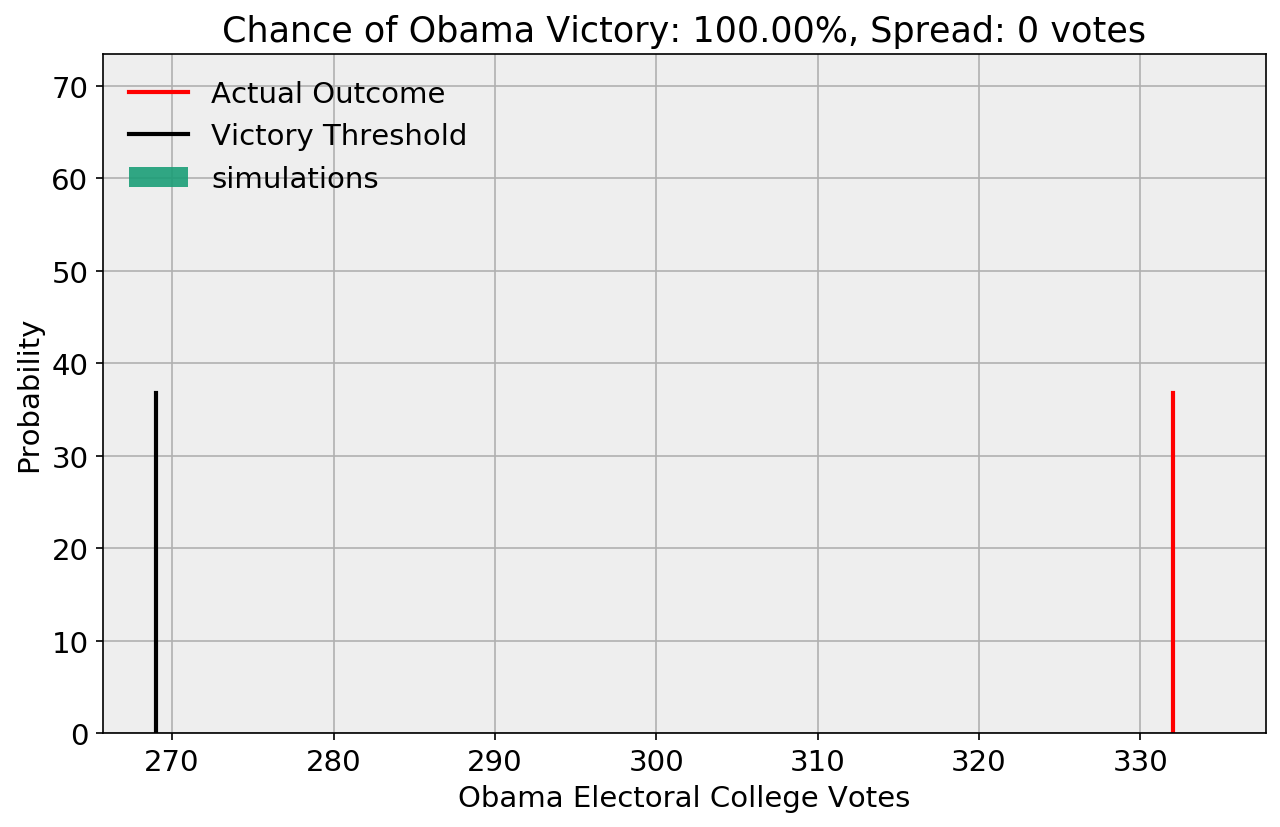

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


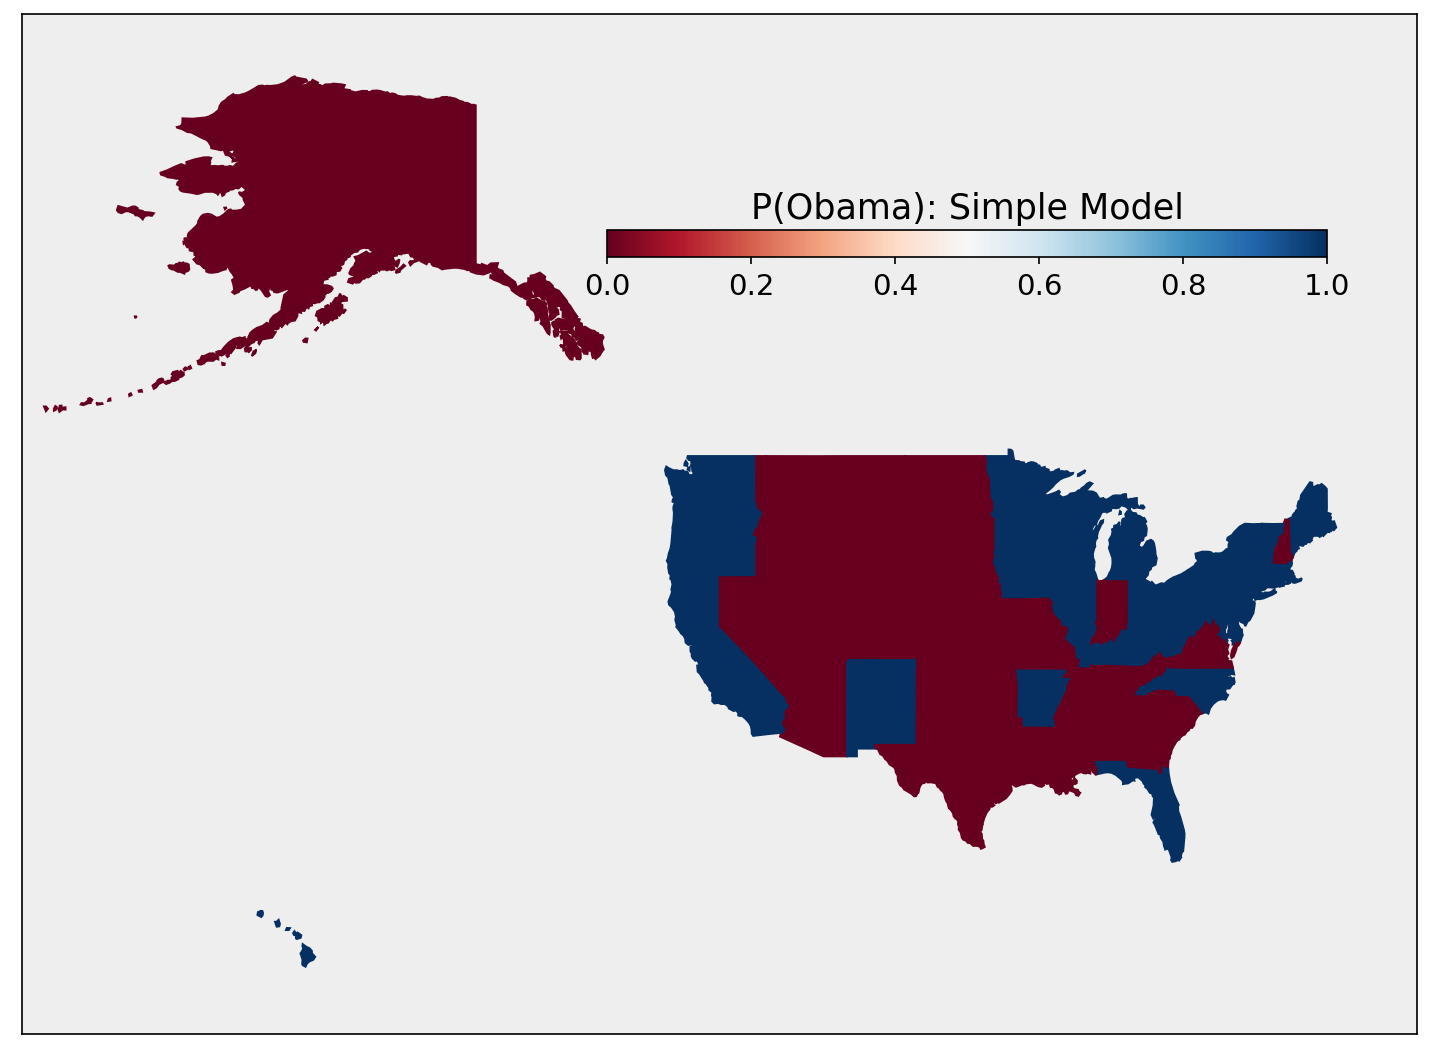

In [104]:
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

#### Adding Polling Uncertainty to the Predictive Model

The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. This is clearly wrong -- there are numerous sources of uncertainty in estimating election outcomes from a poll of affiliations. 

The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll *everybody* in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce?

On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. (The calculation of the sampling error itself is an exercise in statistics. Its fun to think of how you could arrive at the sampling error if it was not given to you. One way to do it would be to assume this was a two-choice situation and use binomial sampling error for the non-unknown answers, and further model the error for those who answered 'Unknown'.)


In [110]:
"""
Function
--------
uncertain_gallup_model

A forecast that predicts an Obama (Democratic) victory if the random variable drawn
from a Gaussian with mean Dem_Adv and standard deviation 3% is >0

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama.
    model.index should be set to gallup.index (that is, it should be indexed by state name)
"""

from scipy.special import erf

def uncertain_gallup_model(gallup):
    sigma = 3
    prob = 0.5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2*sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)

In [111]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(electoral_votes)

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


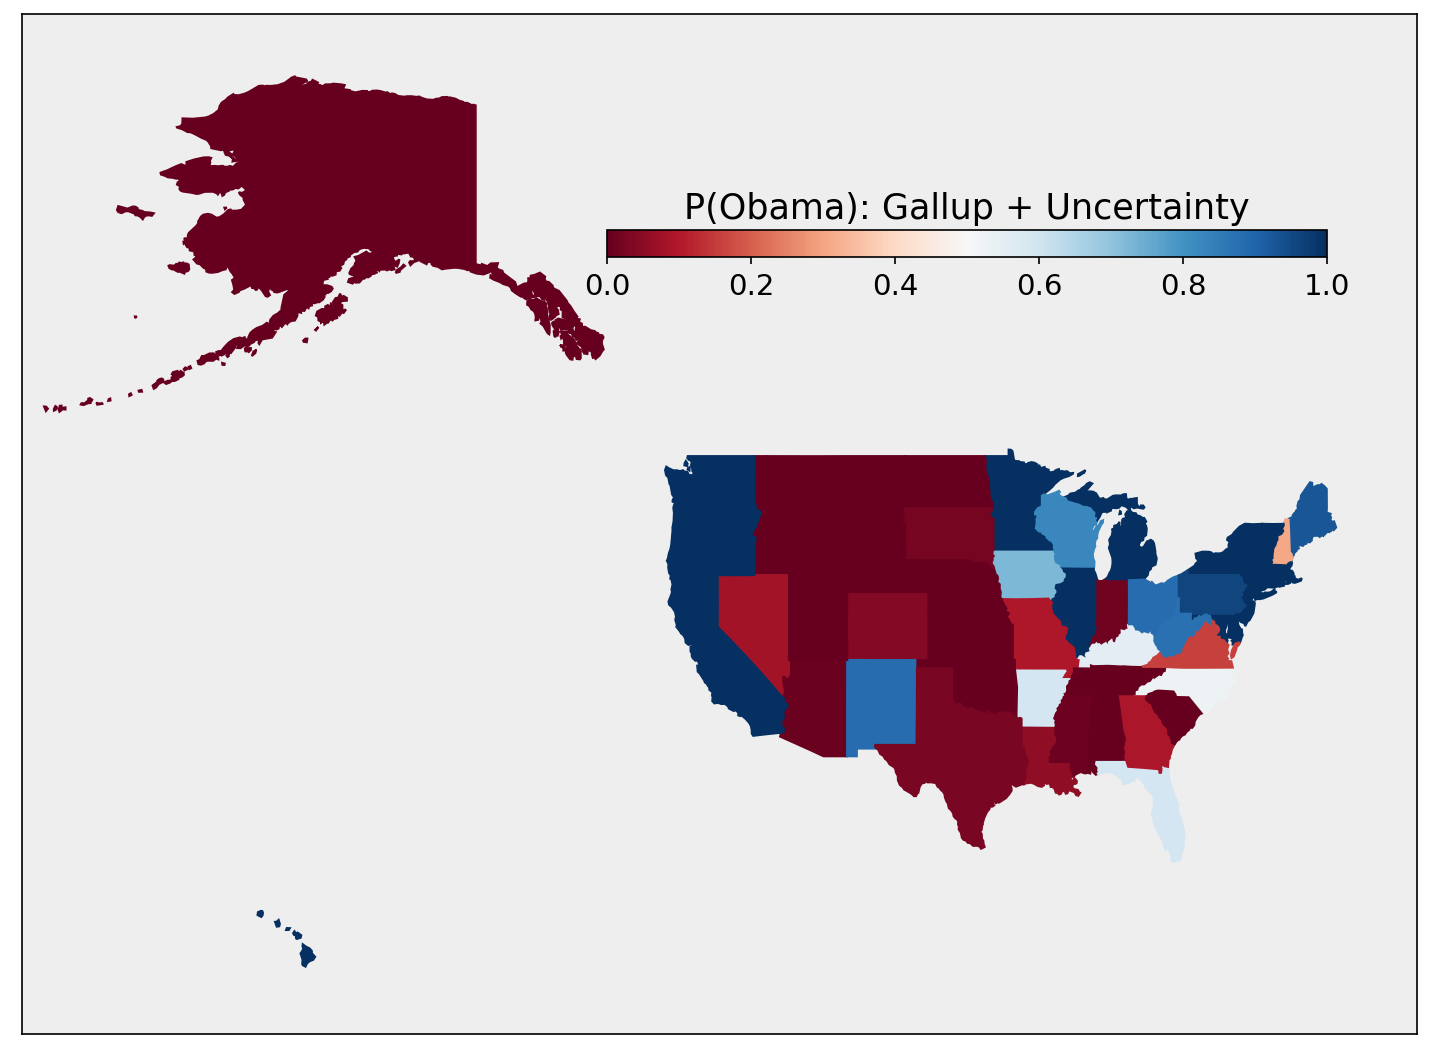

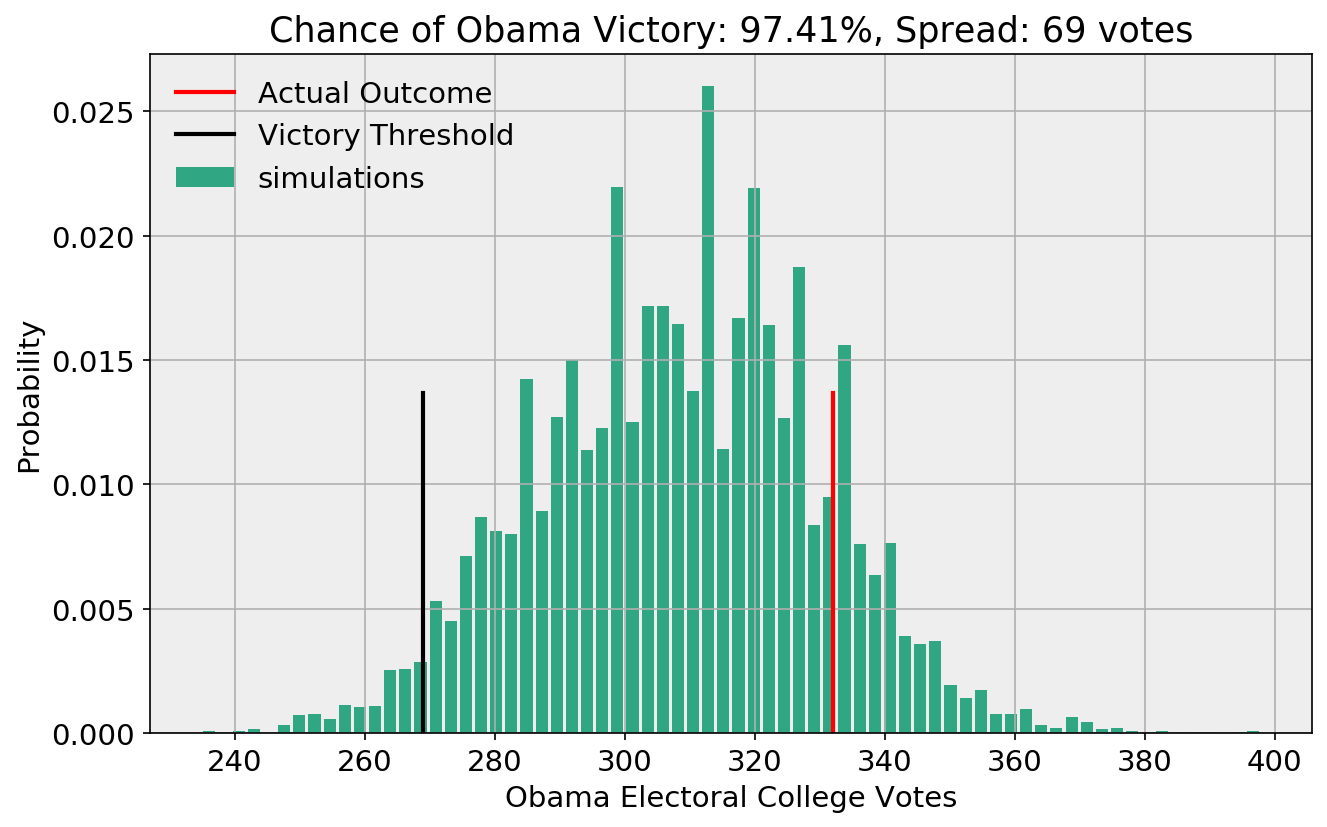

In [112]:
make_map(model.Obama, "P(Obama): Gallup + Uncertainty")
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

The above predictive distribution is consistent with the real data -- the real outcome seems like a typical outcome according to the model. The accuracy is not very good as the center of the distribution falls fairly far from the observed outcome, but the precision is only marginally worse than in the predictwise case.


#### Biases

While accounting for uncertainty is one important part of making predictions, we also want to avoid systematic errors. We call systematic over- or under-estimation of an unknown quantity **bias**. In the case of this forecast, our predictions would be biased if the estimates from this poll *systematically* over- or under-estimate vote proportions on election day. There are several reasons this might happen:

1. **Gallup is wrong**. The poll may systematically over- or under-estimate party affiliation. This could happen if the people who answer Gallup phone interviews might not be a representative sample of people who actually vote, Gallup's methodology is flawed, or if people lie during a Gallup poll.
1. **Our assumption about party affiliation is wrong**. Party affiliation may systematically over- or under-estimate vote proportions. This could happen if people identify with one party, but strongly prefer the candidate from the other party, or if undecided voters do not end up splitting evenly between Democrats and Republicans on election day.
1. **Our assumption about equilibrium is wrong**. This poll was released in August, with more than two months left for the elections. If there is a trend in the way people change their affiliations during this time period (for example, because one candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.

One way to account for bias is to calibrate our model by estimating the bias and adjusting for it. Before we do this, let's explore how sensitive our prediction is to bias.

In [115]:
"""
Function
--------
biased_gallup_poll

Subtracts a fixed amount from Dem_Adv, beofore computing the uncertain_gallup_model.
This simulates correcting a hypothetical bias towards Democrats
in the original Gallup data.

Inputs
-------
gallup : DataFrame
    The Gallup party affiliation data frame above
bias : float
    The amount by which to shift each prediction
    
Examples
--------
>>> model = biased_gallup(gallup, 1.)
>>> model.ix['Flordia']
>>> .460172
"""
#your code here
def biased_gallup_poll(gallup,bias):
    g2 = gallup.copy()
    g2.Dem_Adv -= bias
    return uncertain_gallup_model(g2)  

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


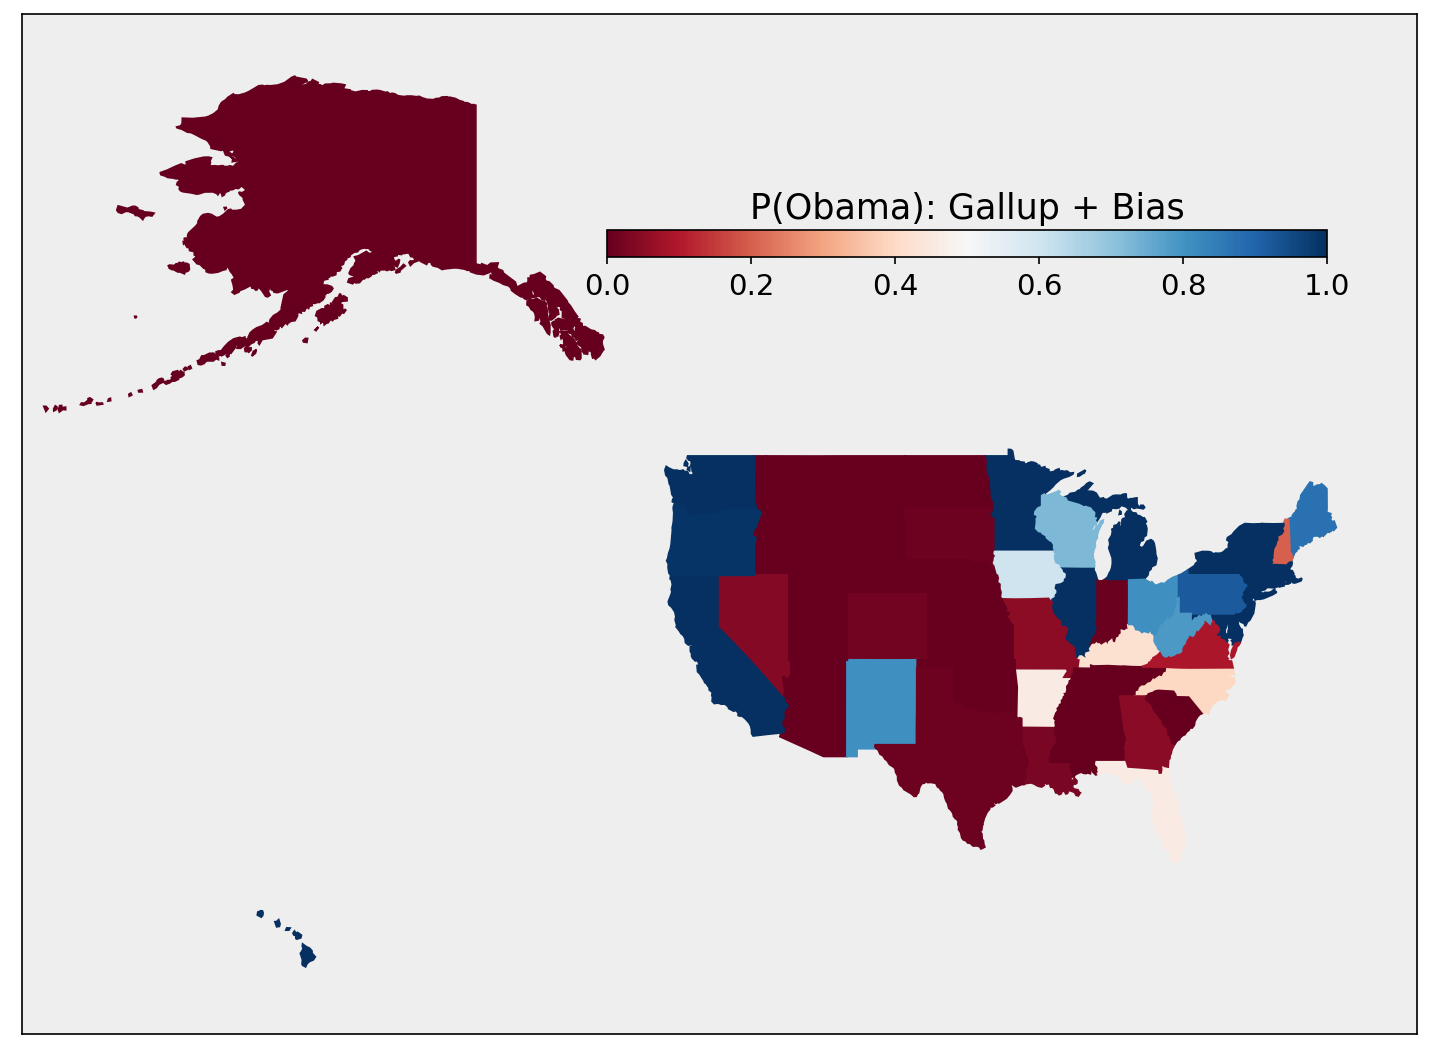

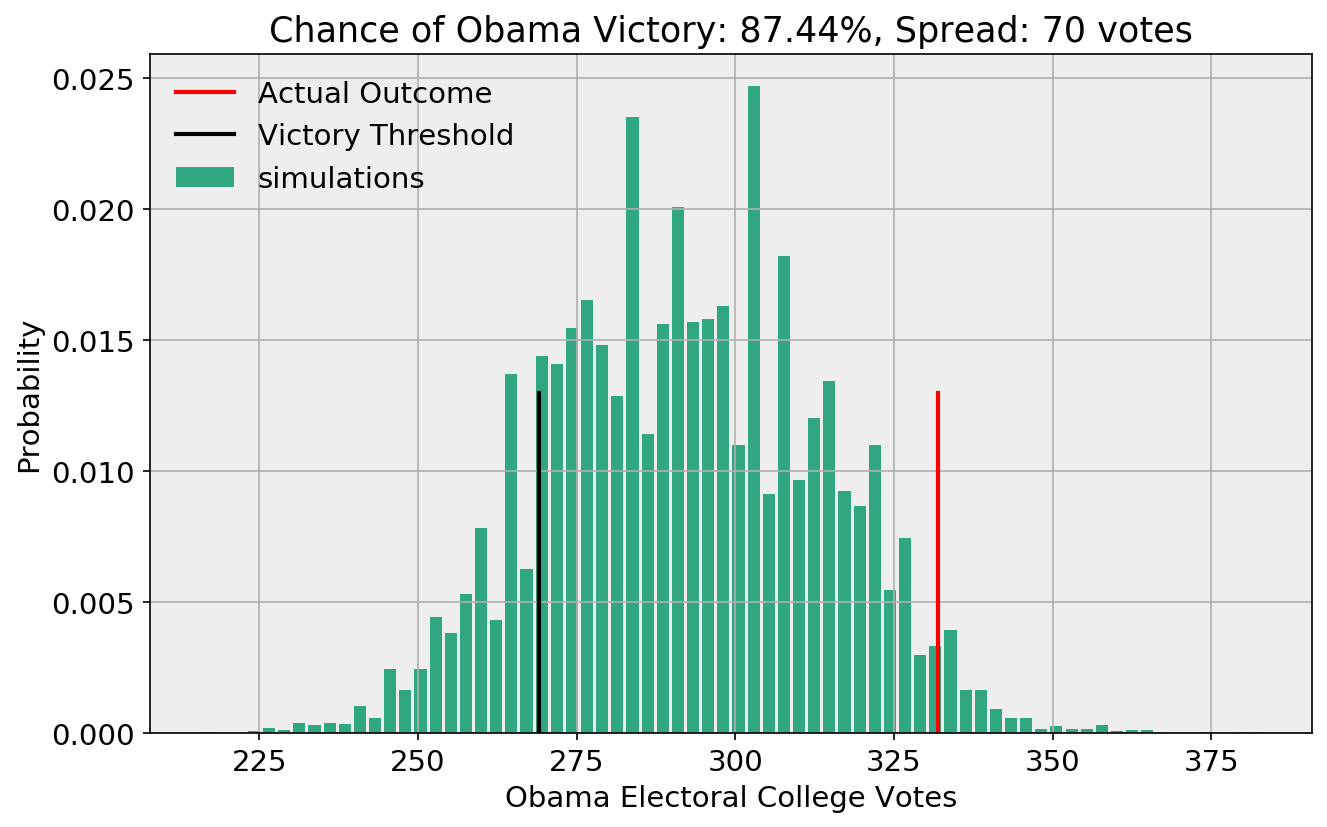

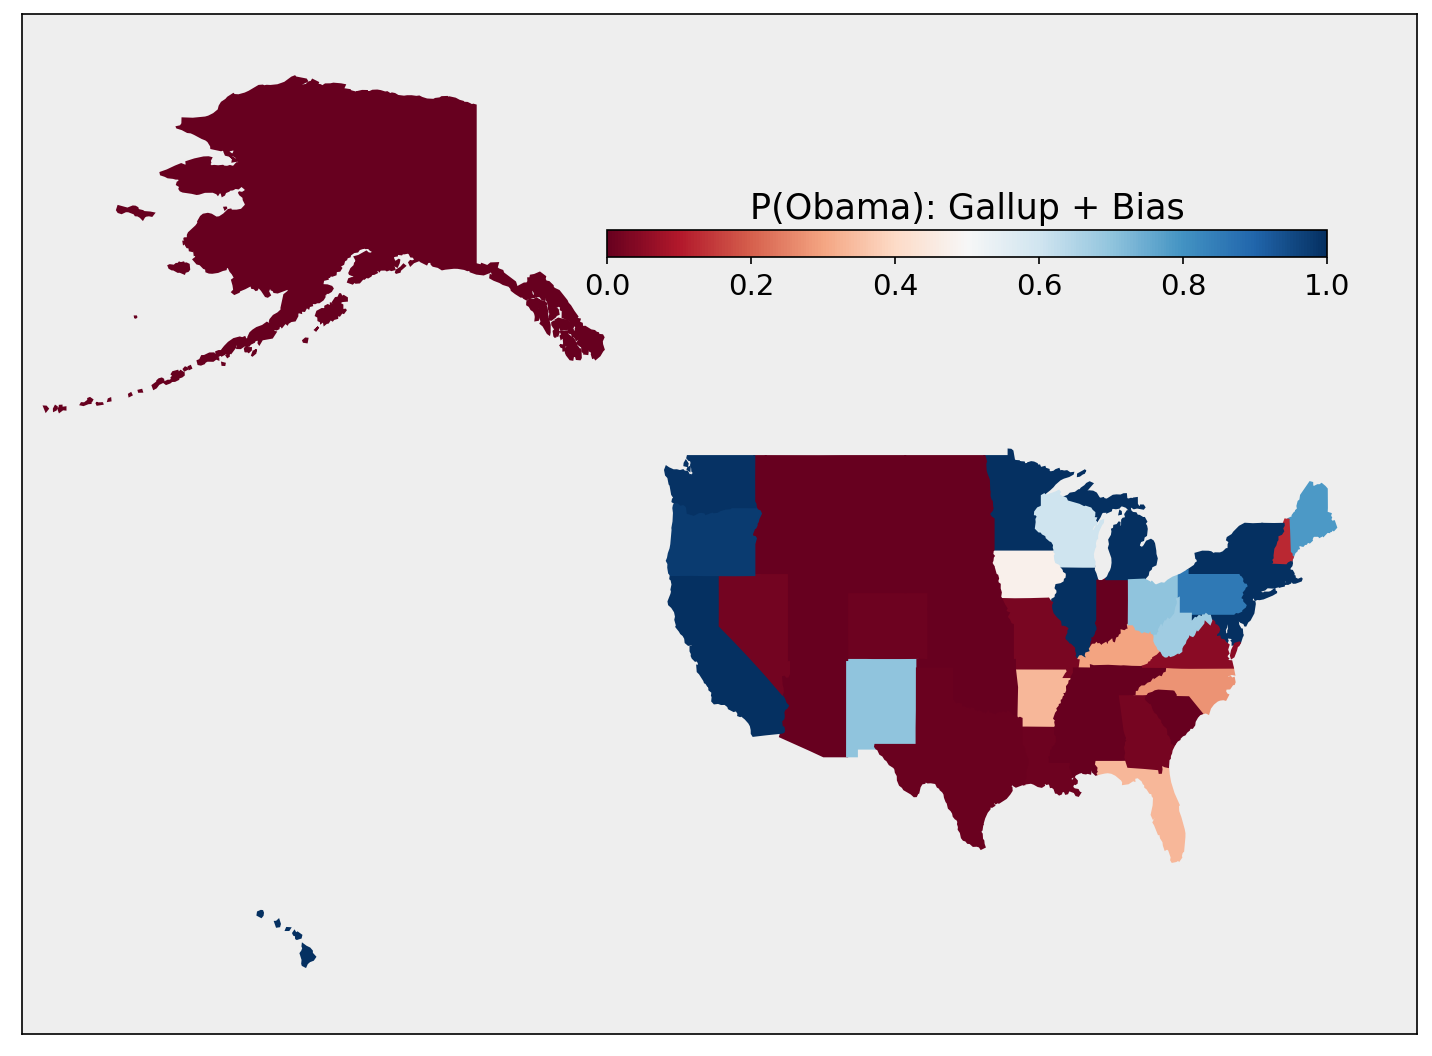

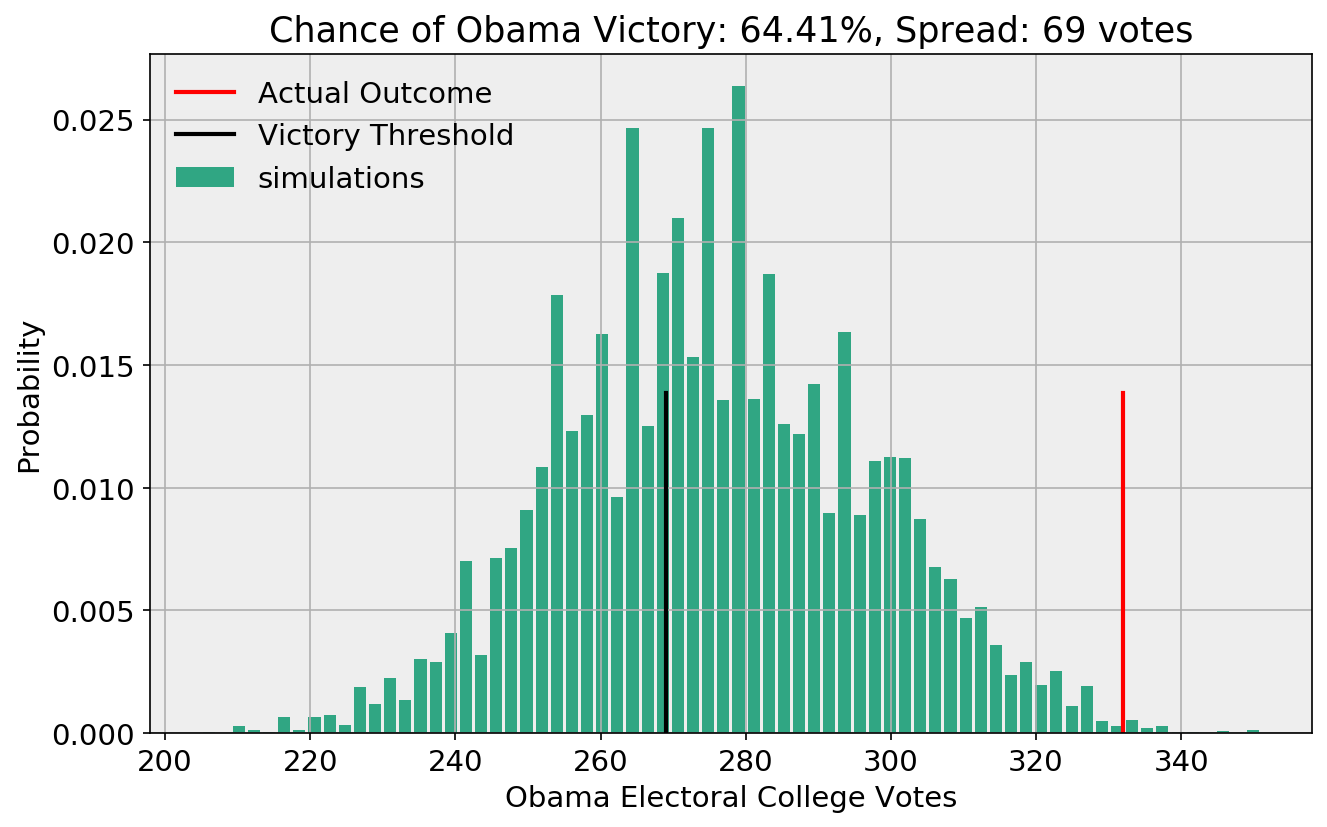

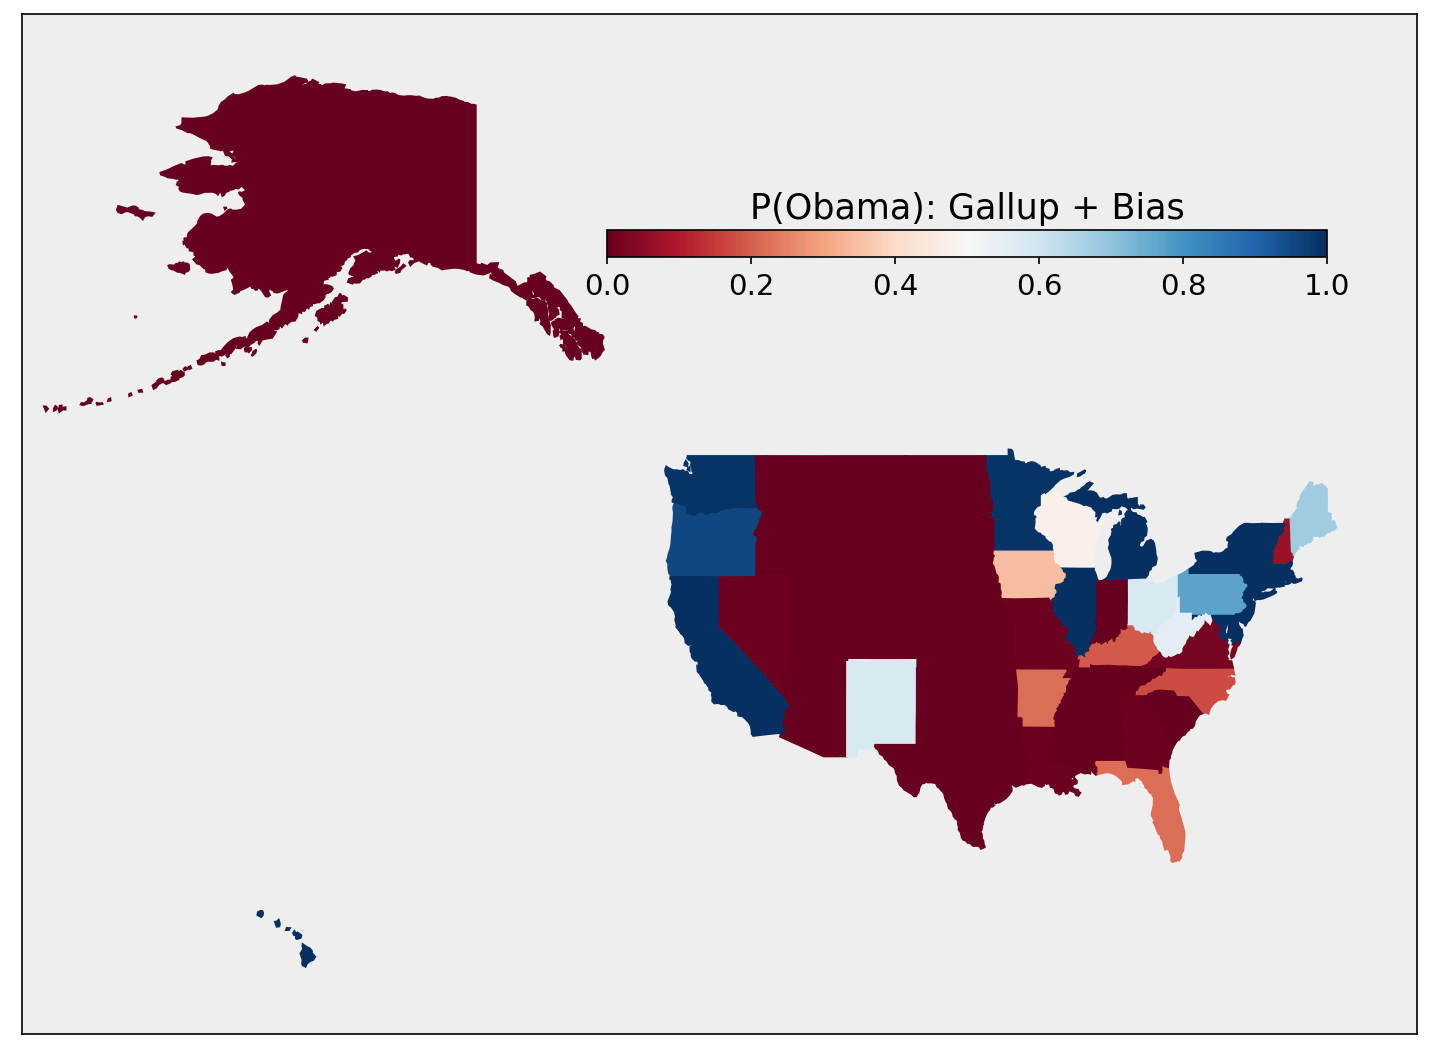

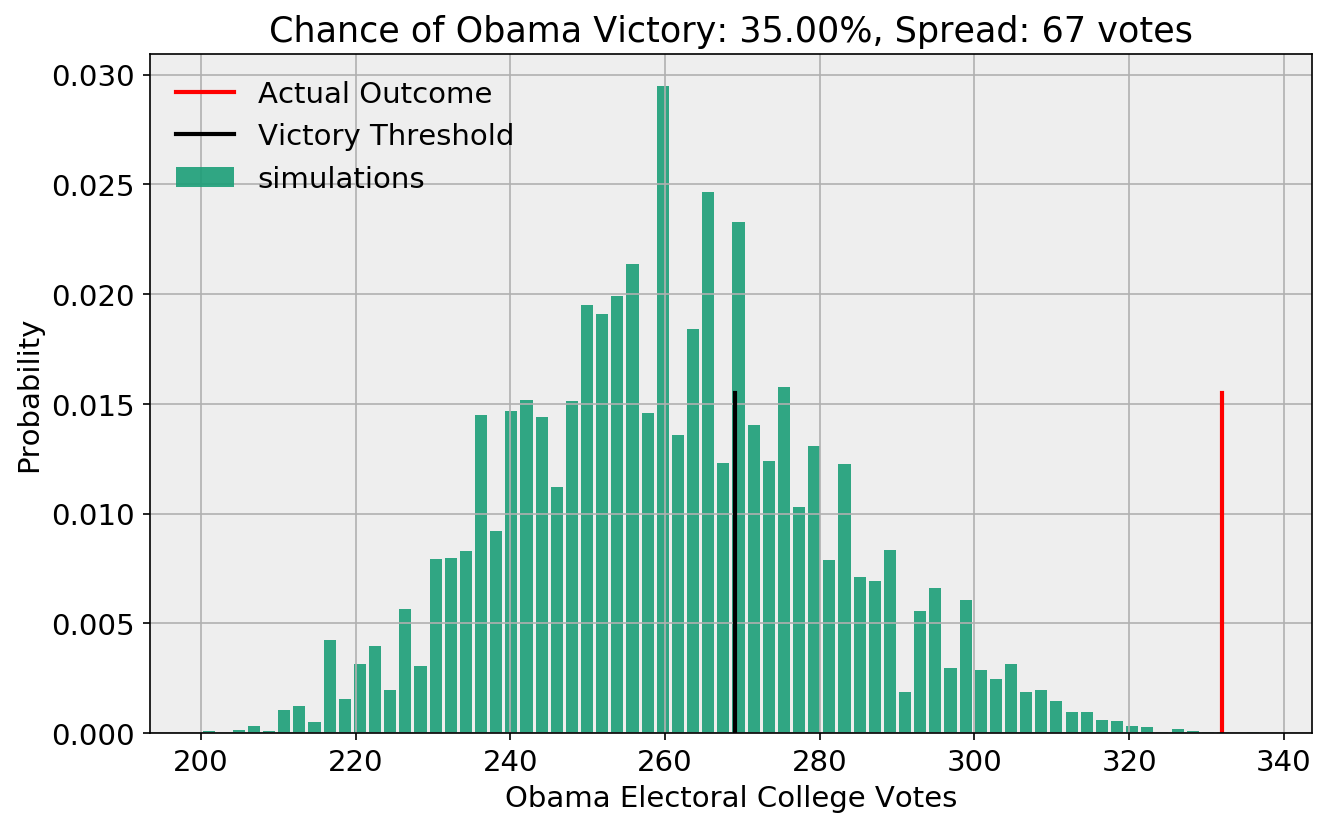

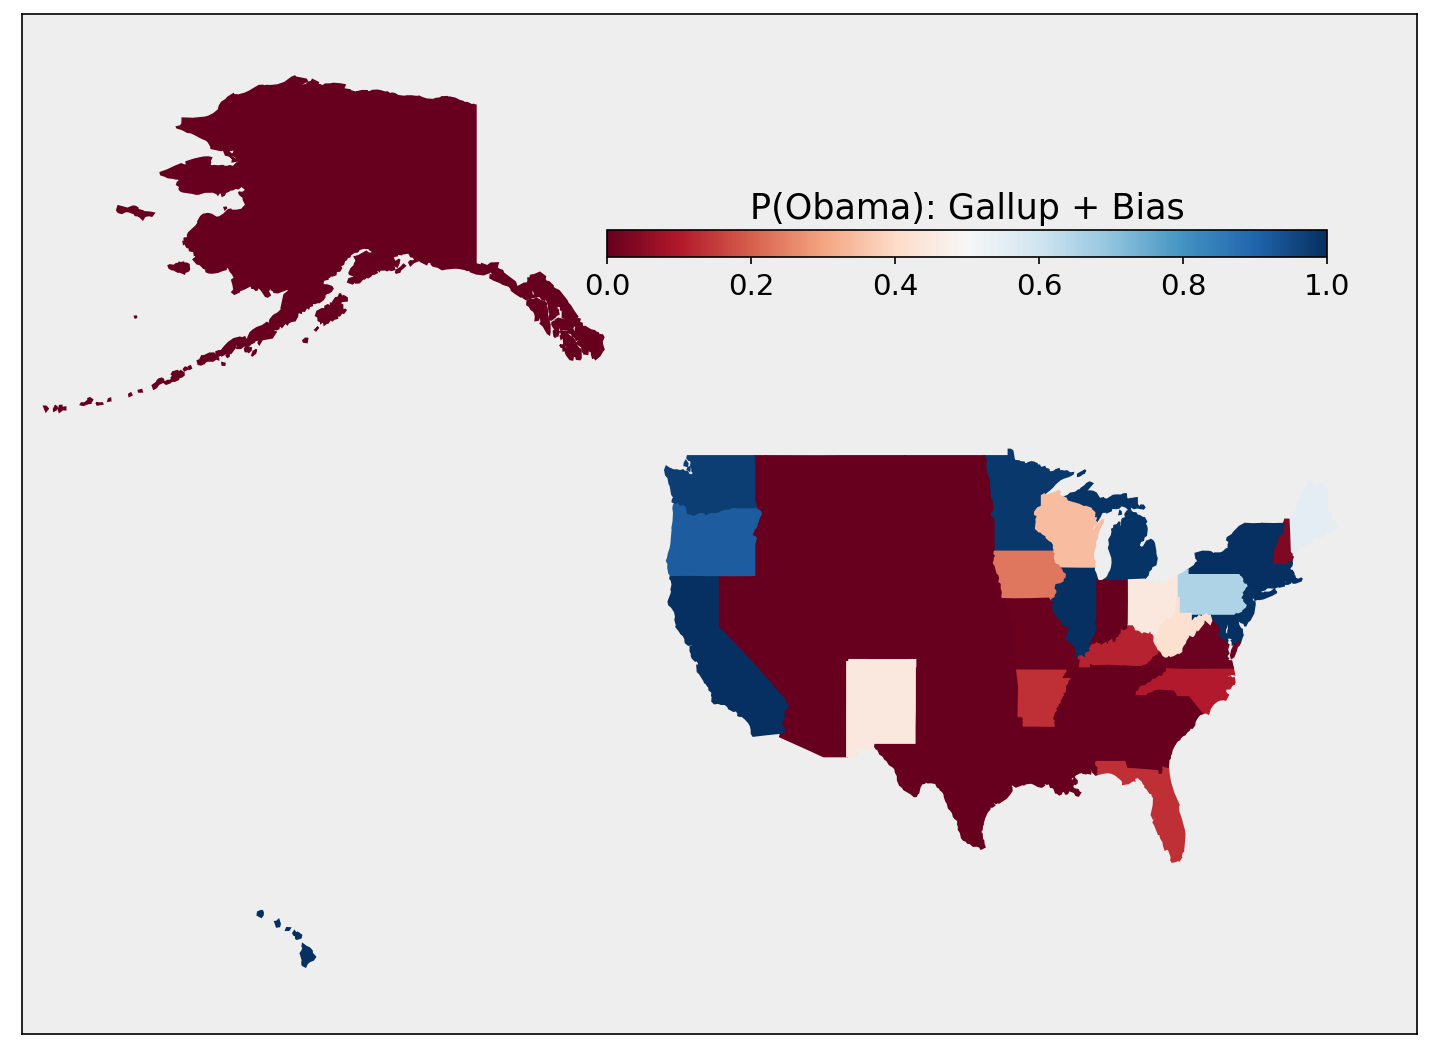

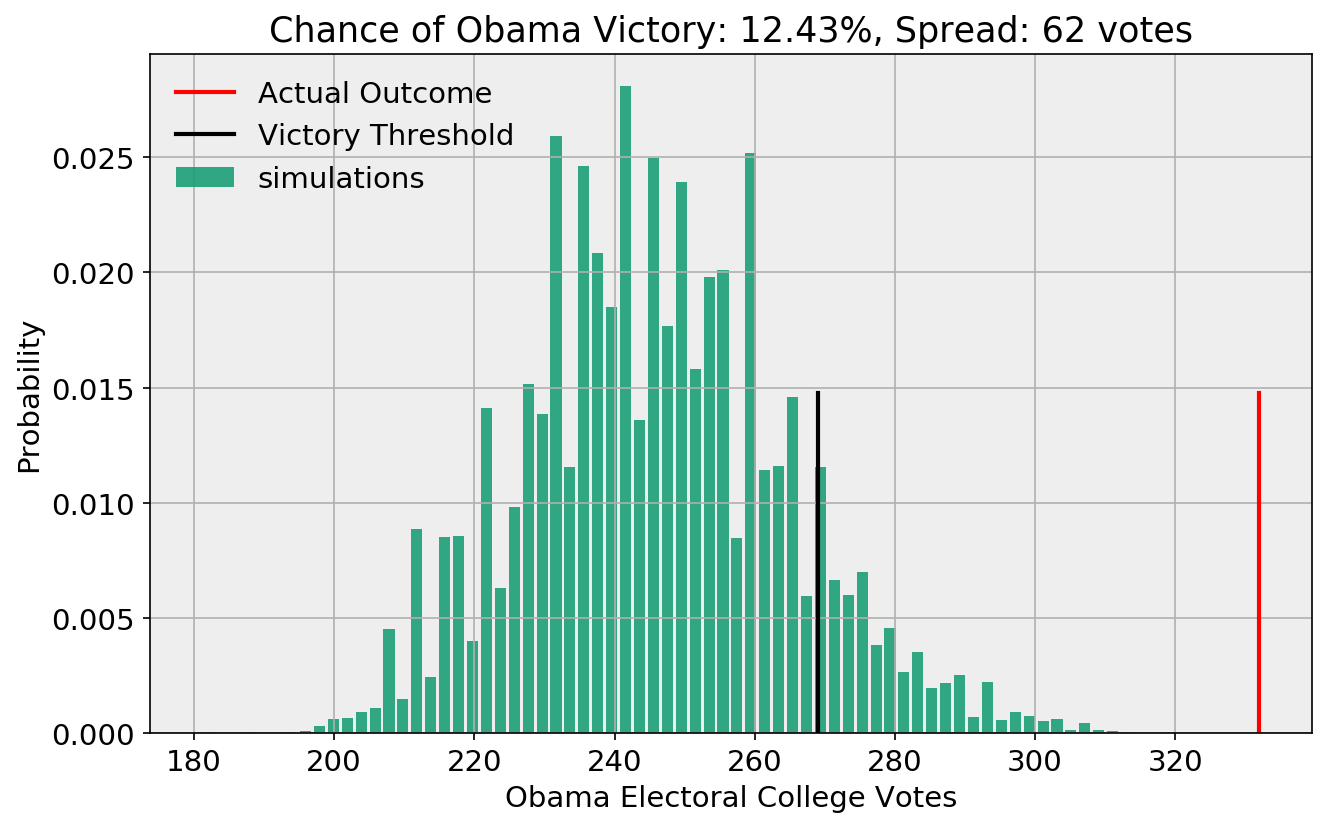

In [117]:
for i in range(1,5):
    model = biased_gallup_poll(gallup_2012,i)
    model = model.join(electoral_votes)
    make_map(model.Obama, "P(Obama): Gallup + Bias")
    plt.show()
    prediction = simulate_election(model, 10000)
    plot_simulation(prediction)

Note that even a small bias can have a dramatic effect on the predictions. Pundits made a big fuss about bias during the last election, and for good reason -- it's an important effect, and the models are clearly sensitive to it. Forecastors like Nate Silver would have had an easier time convincing a wide audience about their methodology if bias wasn't an issue.

Furthermore, because of the nature of the electoral college, biases get blown up large. For example, suppose you mis-predict the party Florida elects. We've possibly done this as a nation in the past :-). Thats 29 votes right there. So, the penalty for even one misprediction is high.

#### Estimating the size of the bias from the 2008 election

While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct *if* we are able to estimate the size of the bias and adjust for it. This is one form of **calibration**.

One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.

In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [118]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Dem_Adv  Dem_Win
State                       
Alabama        -0.8   -21.58
Alaska        -10.6   -21.53
Arizona        -0.4    -8.52
Arkansas       12.5   -19.86
California     19.4    24.06

[  1.26390486 -11.32855786]


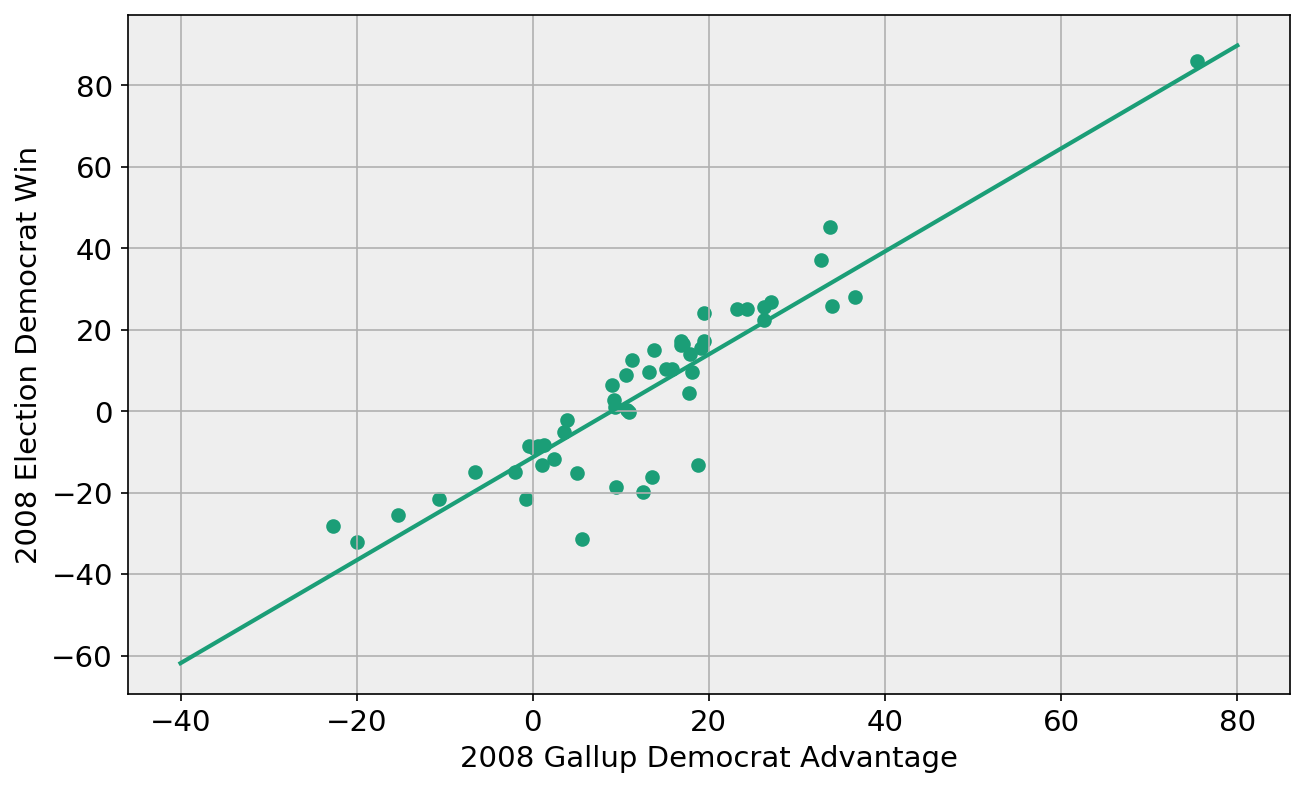

In [127]:
plt.scatter(prediction_08.Dem_Adv,prediction_08.Dem_Win)
plt.xlabel("2008 Gallup Democrat Advantage")
plt.ylabel("2008 Election Democrat Win")
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)
print(fit)

In [129]:
prediction_08[(prediction_08.Dem_Win < 0) & (prediction_08.Dem_Adv > 0)]

Dem_Adv  Dem_Win
State                           
Arkansas           12.5   -19.86
Georgia             3.6    -5.21
Kentucky           13.5   -16.23
Louisiana           9.4   -18.63
Mississippi         1.1   -13.18
Missouri           10.9    -0.14
Montana             3.9    -2.26
North Dakota        0.6    -8.63
Oklahoma            5.6   -31.30
South Carolina      0.1    -8.97
South Dakota        1.3    -8.41
Tennessee           5.0   -15.07
Texas               2.4   -11.77
West Virginia      18.8   -13.12

We compute the average difference between the Democrat advantages in the election and Gallup poll

In [130]:
print((prediction_08.Dem_Adv - prediction_08.Dem_Win).mean())

8.068039215686275


The bias was roughly 8% in favor of the Democrats in the Gallup Poll, meaning that you would want to adjust predictions based on this poll down by that amount. This was the result of people in a number of Southern and Western states claiming to be affiliated as Democrats, then voting the other way. Or, since Gallup kept polling even after the elections, it could also represent people swept away by the 2008 election euphoria in those states. This is an illustration of why one needs to be carefull with polls.

Caliberating the forecast by taking into account the bias.

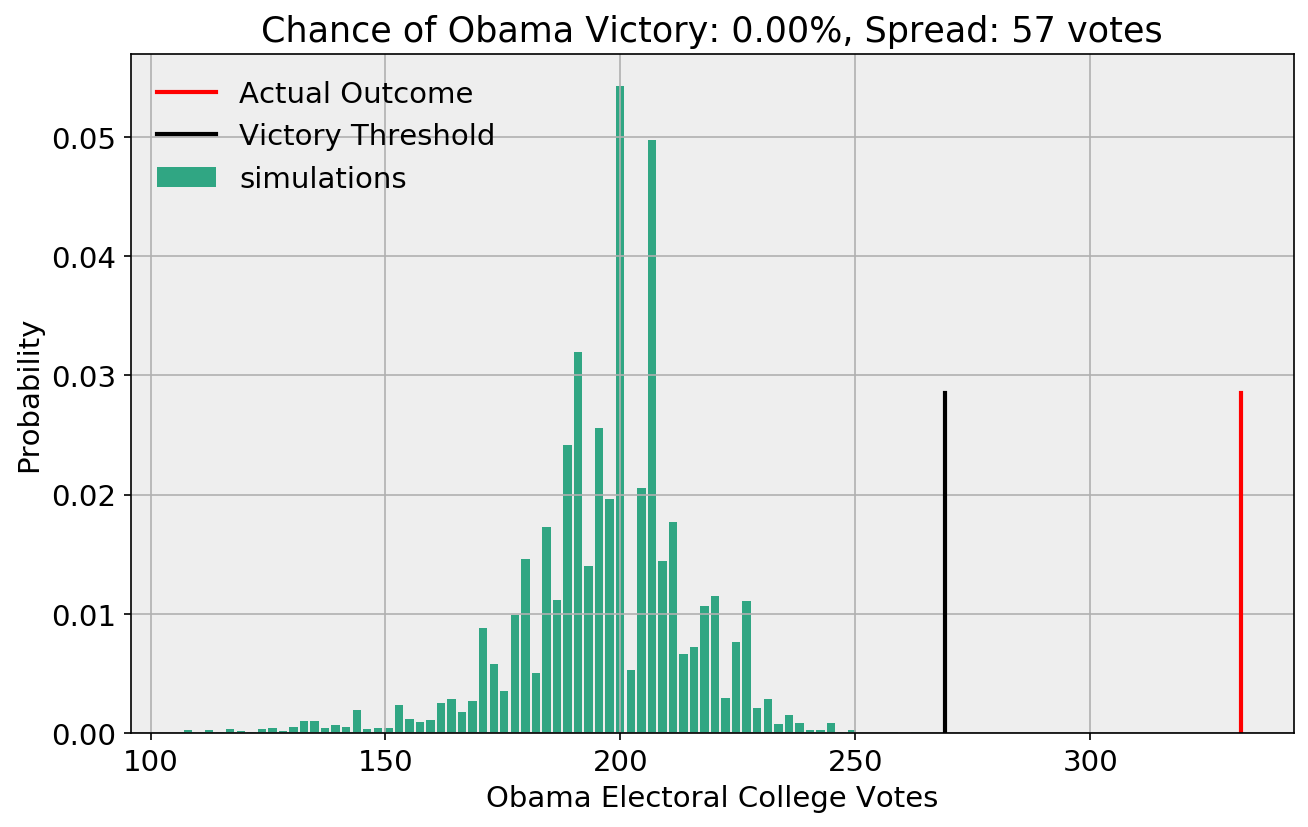

In [132]:
model = biased_gallup_poll(gallup_2012, 8.06)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

This was a disaster. The 8% calibration completey destroys the accuracy of our prediction in 2012. Our calibration made the assumptions that a) the bias in 2008 was the same as 2012, and b) the bias in each state was the same.

There are several ways in which these assumptions may have been violated. Gallup may have changed their methodology to account for this bias already, leading to a different bias in 2012 from what there was in 2008. The state-by-state biases may have also been different -- voters in highly conservative states may have responded to polls differently from voters in libreral states, for instance. It might have been better to callibrate the bias on a state-wide or clustered basis.


## Logistic Considerations

In the previous forecast, we used the strategy of taking some side-information about an election (the partisan affiliation poll) and relating that to the predicted outcome of the election. We tied these two quantities together using a very simplistic assumption, namely that the vote outcome is deterministically related to estimated partisan affiliation.

In this section, we use a more sophisticated approach to link side information -- usually called **features** or **predictors** -- to our prediction. This approach has several advantages, including the fact that we may use multiple features to perform our predictions. Such data may include demographic data, exit poll data, and data from previous elections.

First, we'll construct a new feature called PVI, and use it and the Gallup poll to build predictions. Then, we'll use **logistic regression** to estimate win probabilities, and use these probabilities to build a prediction.

#### The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state. In other words:

$$
PVI_{2008} (state) = 
Democratic.Percent_{2004} ( state ) - Republican.Percent_{2004} ( state) - \\ 
                \Big ( Democratic.Percent_{2004} (national) - Republican.Percent_{2004} (national) \Big )
$$

To calculate it, let us first load the national percent results for republicans and democrats in the last 3 elections and convert it to the usual `democratic - republican` format.

In [133]:
national_results=pd.read_csv("data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

Dem  Rep
Year          
2004   48   51
2008   53   46
2012   51   47

Let us also load in data about the 2004 elections from `p04.csv` which gets the results in the above form for the 2004 election for each state.

In [134]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

Dem  Rep
State               
Alabama      37   63
Alaska       34   62
Arizona      44   55
Arkansas     45   54
California   54   45

In [135]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [176]:
e2008 = pd.DataFrame(dict(Dem_Adv = prediction_08.Dem_Adv - prediction_08.Dem_Adv.mean(),Dem_Win = prediction_08.Dem_Win,pvi = pvi08))
e2008['obama_win'] = 1*(prediction_08.Dem_Win > 0)
e2008 = e2008.sort_index()
e2008

Dem_Adv  Dem_Win  pvi  obama_win
State                                                   
Alabama              -13.154902   -21.58  -23          0
Alaska               -22.954902   -21.53  -25          0
Arizona              -12.754902    -8.52   -8          0
Arkansas               0.145098   -19.86   -6          0
California             7.045098    24.06   12          1
Colorado              -1.754902     8.95   -4          1
Connecticut           13.945098    22.37   13          1
Delaware              10.845098    24.99   10          1
District of Columbia  63.045098    85.93   84          1
Florida               -3.154902     2.81   -2          1
Georgia               -8.754902    -5.21  -15          0
Hawaii                21.445098    45.27   14          1
Idaho                -27.654902   -25.43  -37          0
Illinois              11.945098    25.14   14          1
Indiana               -3.054902     1.04  -18          1
Iowa                   5.745098     9.54    2          1
Kansas               -14.354902   -14.96  -24          0
Kentucky               1.145098   -16.23  -17          0
Louisiana             -2.954902   -18.63  -12          0
Maine                  7.045098    17.33   11          1
Maryland              13.945098    25.45   16          1
Massachusetts         21.645098    25.81   28          1
Michigan               4.745098    16.47    6          1
Minnesota              2.745098    10.24    8          1
Mississippi          -11.254902   -13.18  -17          0
Missouri              -1.454902    -0.14   -5          0
Montana               -8.454902    -2.26  -17          0
Nebraska             -18.954902   -14.93  -32          0
Nevada                -1.054902    12.50    0          1
New Hampshire          0.845098     9.61    4          1
New Jersey             6.745098    15.57   10          1
New Mexico             1.445098    15.13    2          1
New York              14.645098    26.69   21          1
North Carolina        -1.654902     0.32  -11          1
North Dakota         -11.754902    -8.63  -24          0
Ohio                   5.345098     4.54    1          1
Oklahoma              -6.754902   -31.30  -29          0
Oregon                 4.445098    16.35    9          1
Pennsylvania           3.445098    10.35    5          1
Rhode Island          24.245098    27.92   24          1
South Carolina       -12.254902    -8.97  -14          0
South Dakota         -11.054902    -8.41  -20          0
Tennessee             -7.354902   -15.07  -11          0
Texas                 -9.954902   -11.77  -20          0
Utah                 -35.054902   -28.17  -43          0
Vermont               20.345098    37.01   23          1
Virginia              -3.354902     6.30   -5          1
Washington             4.445098    17.17   10          1
West Virginia          6.445098   -13.12  -10          0
Wisconsin              5.445098    13.91    4          1
Wyoming              -32.354902   -32.24  -37          0

We construct a similar frame for 2012, obtaining `pvi` using the 2008 Obama win data which we already have. There is no `obama_win` column since, well, our job is to predict it!

In [175]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean(),pvi=pvi12))
e2012 = e2012.sort_index()
e2012.head()

Dem_Adv    pvi
State                       
Alabama    -14.684314 -28.58
Alaska      -9.484314 -28.53
Arizona     -8.584314 -15.52
Arkansas    -0.384314 -26.86
California  12.615686  17.06

We load in the actual 2012 results so that we can compare our results to the predictions.

In [142]:
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

Winner
State             
Alabama          0
Alaska           0
Arizona          0
Arkansas         0
California       1

#### Exploratory Data Analysis

Plotting a scatter-plot between the pvi's of 2004 vs that of 2008.

[0.98549669 0.28199975]


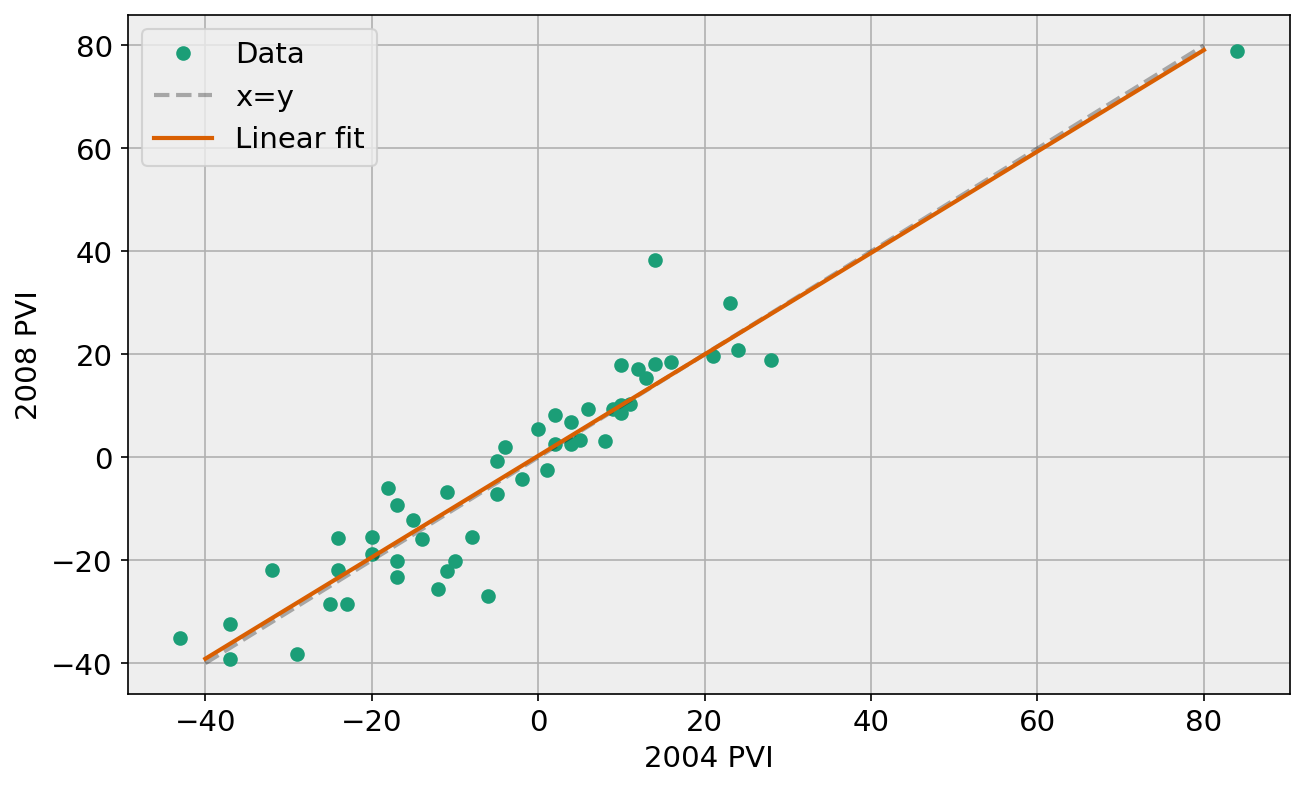

In [148]:
plt.plot(e2008.pvi, e2012.pvi, 'o', label='Data')
fit = np.polyfit(e2008.pvi, e2012.pvi, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, x, '--k', alpha=.3, label='x=y')
plt.plot(x, y, label='Linear fit')
plt.xlabel("2004 PVI")
plt.ylabel("2008 PVI")
plt.legend(loc='upper left')
print(fit)

There is a reasonably well fit line which hugs the `x=y` line. This tells us that the PVI seems relatively stable from election to election and may thus make a good predictor.

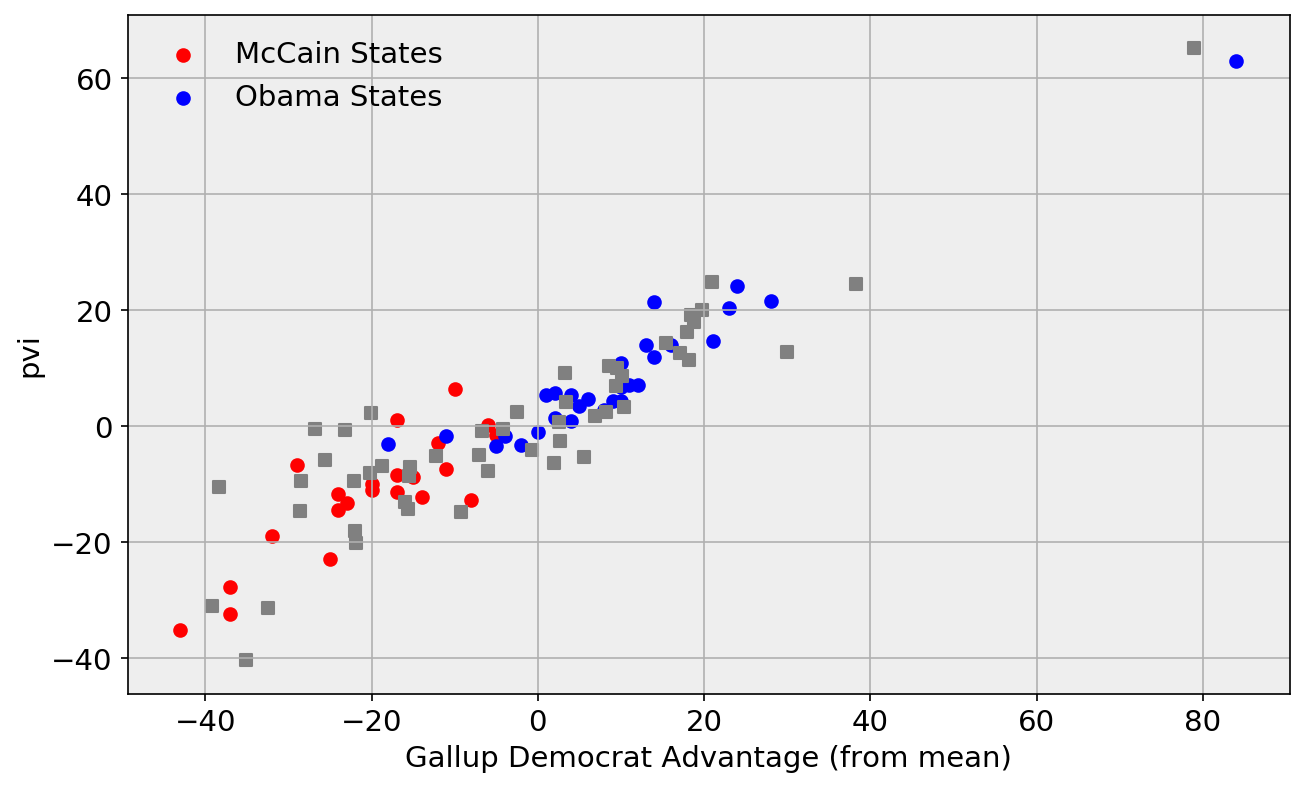

In [163]:
plt.xlabel("Gallup Democrat Advantage (from mean)")
plt.ylabel("pvi")
df = e2008.copy()
df = df[df.obama_win == 0]
df2 = e2008.copy()
df2 = df2[df2.obama_win == 1]
ax=plt.gca()
ax.scatter(df.pvi,df.Dem_Adv,color = 'r',label = 'McCain States')
ax.scatter(df2.pvi,df2.Dem_Adv,color = 'b',label = 'Obama States')
ax.scatter(e2012.pvi,e2012.Dem_Adv,color = 'gray',marker = 's')
plt.legend(frameon=False, scatterpoints=1, loc='upper left')

It seems that with 3-4 misclassifications, we could draw a line to divide the data into two parts.

#### The Logistic Regression

We first build the features from the 2008 data frame, returning `y`, the vector of labels, and `X` the feature-sample matrix where the columns are the features in order from the list `featurelist`, and each row is a data "point".

In [182]:
from sklearn.linear_model import LogisticRegression

def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

We use the above function to get the label vector and feature-sample matrix for feeding to scikit-learn. We then use the usual scikit-learn incantation `fit` to fit a logistic regression model with regularization parameter `C`. The parameter `C` is a hyperparameter of the model, and is used to penalize too high values of the parameter co-efficients in the loss function that is minimized to perform the logistic regression. We build a new dataframe with the usual `Obama` column, that holds the probabilities used to make the prediction. Finally we return a tuple of the dataframe and the classifier instance, in that order.

In [191]:
def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

We are not done yet. In order to estimate `C`, we perform a grid search over many `C` to find the best `C` that minimizes the loss function. For each point on that grid, we carry out a `n_folds`-fold cross-validation. What does this mean?

Suppose `n_folds=10`. Then we will repeat the fit 10 times, each time randomly choosing 50/10 ~ 5 states out as a test set, and using the remaining 45/46 as the training set. We use the average score on the test set to score each particular choice of `C`, and choose the one with the best performance.

In [192]:
from sklearn.model_selection import GridSearchCV

def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

Finally we write the function that we use to make our fits. It takes both the 2008 and 2012 frame as arguments, as well as the featurelist, and the number of cross-validation folds to do. It uses the above defined `logistic_score` to find the best-fit `C`, and then uses this value to return the tuple of result dataframe and classifier described above. This is the function you will be using.

In [185]:
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

In [193]:
res, clf = cv_and_fit(e2008, e2012, ['Dem_Adv', 'pvi'])
predict2012_logistic = res.join(electoral_votes)
predict2012_logistic.head()

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

Obama  Votes
State                      
Alabama     0.004367      9
Alaska      0.008462      3
Arizona     0.068250     11
Arkansas    0.033851      6
California  0.994326     55

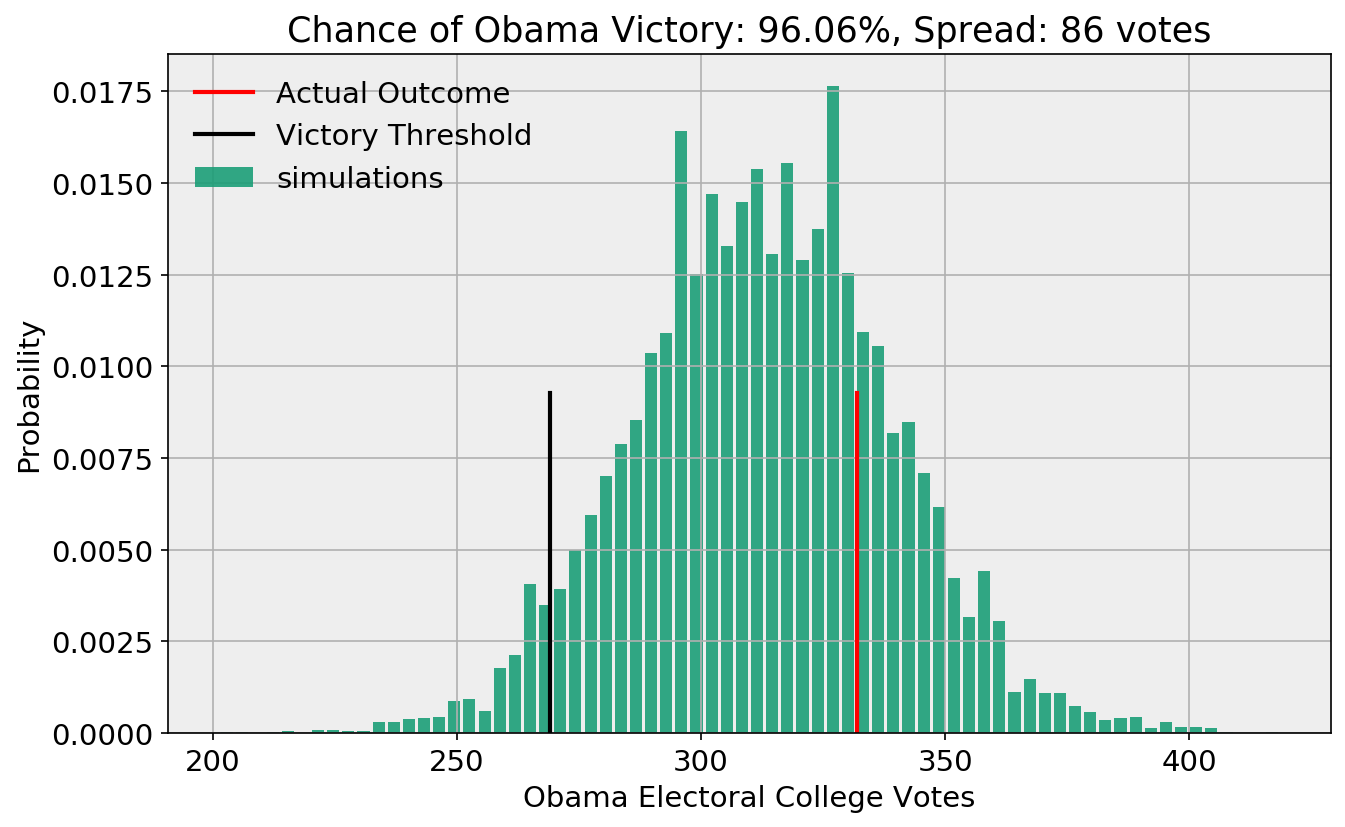

In [194]:
prediction = simulate_election(predict2012_logistic, 10000)
plot_simulation(prediction)

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


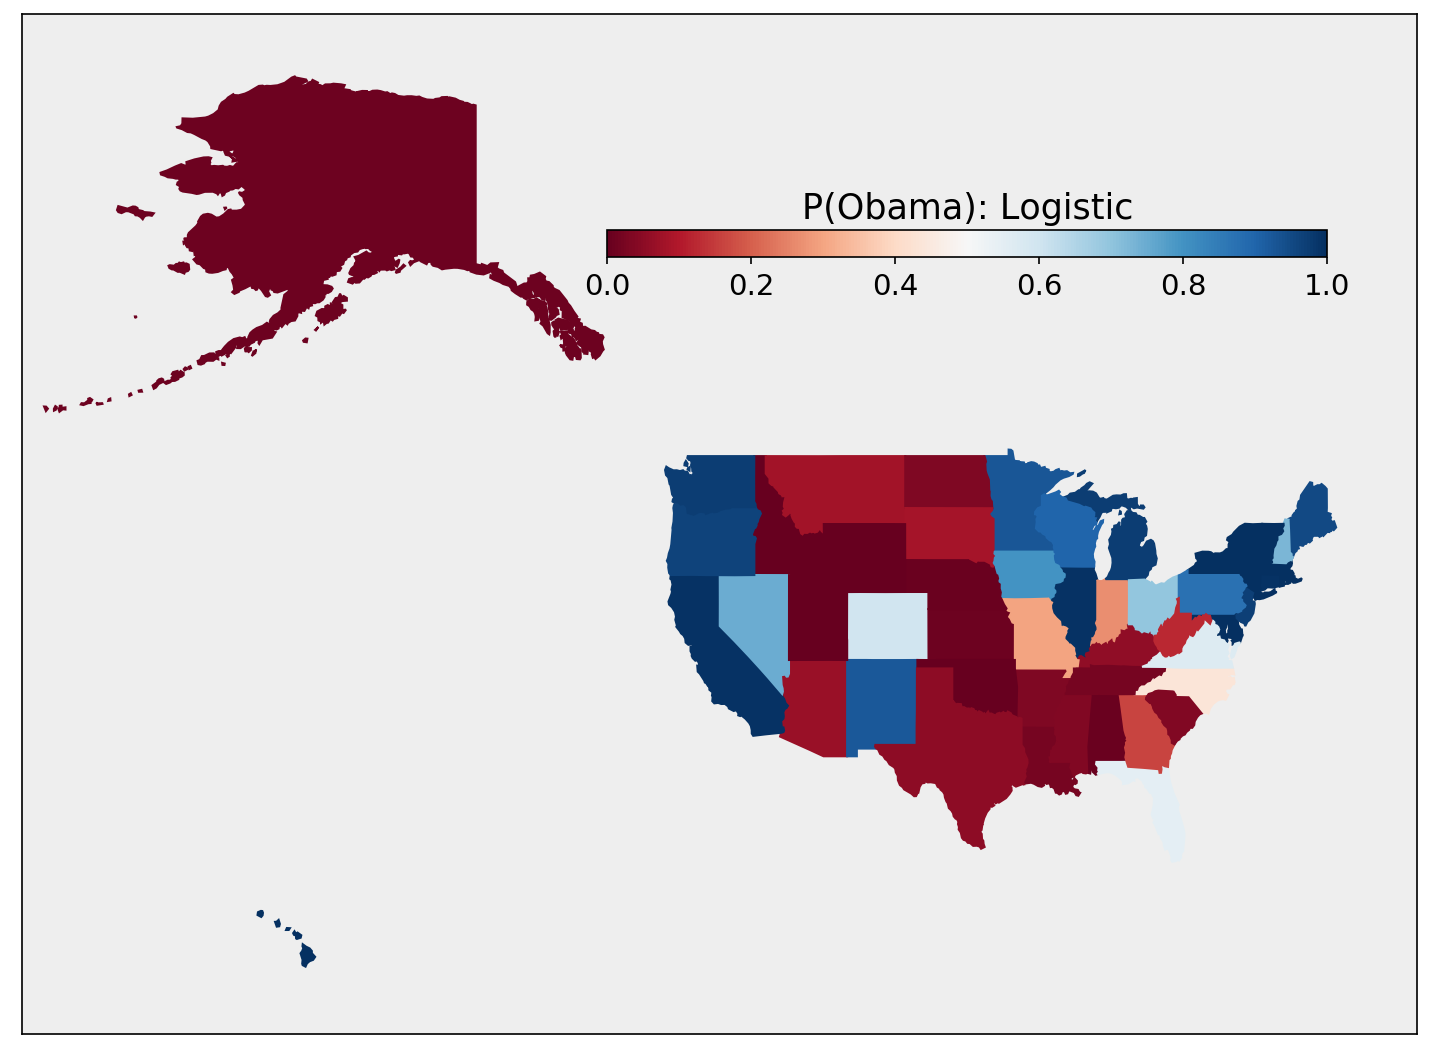

In [195]:
make_map(predict2012_logistic.Obama, "P(Obama): Logistic")

The precision has worsened with respect to the predictwise (and even the gallup) model. The accuracy has improved with respect to the gallup model, but is not as good as in the predictwise model.

In [189]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax

Text(0, 0.5, 'PVI')

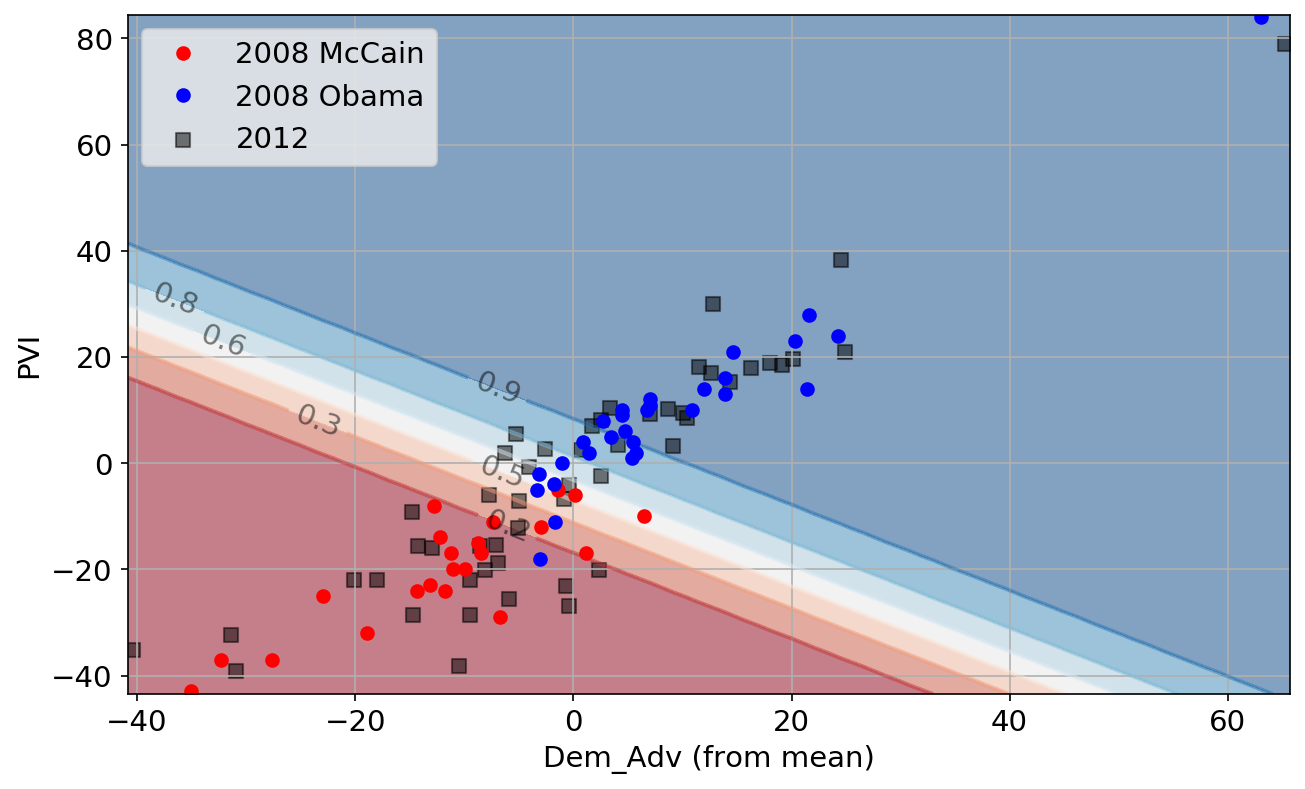

In [196]:
#your code here
points_plot(e2008, e2012, clf)
plt.xlabel("Dem_Adv (from mean)")
plt.ylabel("PVI")

The sharpness of the classifier boundary, as defined by the closeness of the contours near a probability of 0.5 gives us a sense of precision. Imagine that the boundary is very tight, tighter than what you can see in the graph. Then most states will be away from the 0.5 line, and the spread in the results will be less, or the precision higher. This is not the only consideration: indeed one must ask, how many states fall smack into the middle, say between 0.3 and 0.7. The more that do, the less precise the results will be, as there will be a greater number of simulations in which they will cross-over to another party. 

To assess accuracy, we would have to see the actual outcome of the states in 2012. Accuracy would be a function of the number of states that end up on the "wrong" side of the 0.5 line, and how deep they end up on the wrong side. In terms of characterizing the 2008 outcomes, it seems that the classifier is quit eaccurate, with most misclassifications appearing in grey area of the classification boundary.